In [ ]:
!unzip /content/A.zip

In [2]:
# # initialization
# import cv2
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim
# import torchvision
# from torchvision import datasets, models, transforms
# import matplotlib.pyplot as plt
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# import numpy as np
# import time
# import pandas as pd
# from matplotlib.image import imread
# from torchvision.io import read_image

# import tensorflow as tf
# from keras.applications.resnet50 import ResNet50
# from keras.models import Model
# from keras.layers import Dense, GlobalAveragePooling2D

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
base_dir = "/Users/yijiewang/Documents/WINTER 2024/APS Project/dataset"
DATA_DIR = os.path.join(base_dir, "train")
COLOR_CODES = pd.read_csv(os.path.join(base_dir, "class_dict.csv"))
train_annotations = pd.read_csv(os.path.join(base_dir, "cropped_proportion_train.csv"))
valid_annotations = pd.read_csv(os.path.join(base_dir, "cropped_proportion_valid.csv"))
test_annotations = pd.read_csv(os.path.join(base_dir, "cropped_proportion_test.csv"))
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
])

In [4]:
label_map = {}
for index, row in COLOR_CODES.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [5]:
class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, images_name, targets_name, label_map, transform):
        # self.image_dir = image_dir
        self.transform = transform
        self.label_map = label_map
        self.images_name = images_name
        self.targets_name = targets_name
        self.image_dir = image_dir

    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])

        if not os.path.exists(image_path):
            raise FileNotFoundError(f"Image file does not exist at {image_path}")

        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Failed to read image at {image_path}")
        #print("Success reading image.")

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert RGB

        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self.colormap_to_labelmap(mask)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

    def colormap_to_labelmap(self, mask):
        label_image = np.zeros_like(mask[:,:,0], dtype=np.uint8)

        for label, color in self.label_map.items():
            color_array = np.array(color)
            mask_condition = np.all(mask == color_array, axis=-1)
            label_image[mask_condition] = label

        return label_image.astype(np.float32)

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )
        self.skip = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)
        )

    def forward(self, x):
        conv = self.conv(x)
        skip = self.skip(x)

        plus = conv + skip
        return plus

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = ResidualBlock(3, 64)
        self.dconv_down2 = ResidualBlock(64, 128)
        self.dconv_down3 = ResidualBlock(128, 256)
        self.dconv_down4 = ResidualBlock(256,512)
        self.bottleneck = ResidualBlock(512, 1024)

        self.maxpool = nn.MaxPool2d(2)

        self.dconv1 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dconv2 =  nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dconv3 =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dconv4 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.dconv_up4 = ResidualBlock(1024, 512)
        self.dconv_up3 = ResidualBlock(512, 256)
        self.dconv_up2 = ResidualBlock(256, 128)
        self.dconv_up1 = ResidualBlock(128, 64)
        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):

        # encoder
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1)

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2)

        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3)

        conv4 = self.dconv_down4(x3)
        x4 = self.maxpool(conv4)

        x5 = self.bottleneck(x4)


        x = self.dconv1(x5)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)

        x = self.dconv2(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.dconv3(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.dconv4(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        seg = self.conv_last(x)

        return seg

In [7]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int, torch.LongTensor)): self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list): self.alpha = torch.Tensor(alpha)

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C => N*H*W,C
        target = target.view(-1, 1)

        logpt = F.log_softmax(input)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()

In [8]:
def get_model_name(name, epoch, batch_size):
    """ Generate a name for the model consisting of all the hyperparameter values.
    This can be used to call the path file later for visualization purposes

    Args:
        name: name of the model
        learning_rate: the learning rate of the model
        epoch: the nth iteration of the model
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_lr{1}_epoch{2}_bs{3}_hl{4}".format(name,
                                             epoch,
                                             batch_size)

In [9]:
class Train():
    def __init__(self, model, dataloader, optimizer, num_epoch, device, loss):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epoch = num_epoch
        self.device = device
        self.loss = loss
    def train(self):
        self.model.to(self.device)
        self.model.train()
        train_loss = np.zeros(self.num_epoch)
        for epoch in range(self.num_epoch):
            total_loss = 0.0
            total_samples = 0
            with tqdm(self.dataloader, unit="batch") as dl:
                for inputs, labels in dl:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    predictions = self.model(inputs)
                    labels = labels.squeeze().long()
                    loss = self.loss(predictions, labels)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    total_loss += loss.item() * inputs.size(0)
                    total_samples += inputs.size(0)
                    dl.set_postfix({"Epoch": epoch + 1, "Loss": total_loss / total_samples})
            epoch_loss = total_loss / total_samples
            print(f"Epoch [{epoch + 1}/{self.num_epochs}], Loss: {epoch_loss:.4f}")

            model_path = get_model_name(self.model.name, epoch, self.batch_size)
            torch.save(self.model.state_dict(), model_path)

            train_loss[epoch] = epoch_loss

            epochs = np.arange(1, self.num_epochs + 1)
            np.savetxt("{}_train_loss.csv".format(model_path), train_loss)

In [10]:
images_name = sorted(train_annotations['sat_image_path'])
images_name = images_name[:2500]
labels_name = sorted(train_annotations['mask_path'])
labels_name = labels_name[:2500]
img_dir = "/Users/yijiewang/Documents/WINTER 2024/APS Project/dataset"

In [11]:
num_classes = len(label_map.keys())
lr = 0.001
batch_size = 32
model = UNet(n_class=num_classes)
train_dataset = Segmentation_Dataset(img_dir, images_name, labels_name, label_map, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr)
num_epochs = 30
device =  torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = FocalLoss()

In [12]:
model.load_state_dict(torch.load('apr3.pth', map_location=device))
#trained 524 images

<All keys matched successfully>

In [13]:
trainer = Train(model, train_dataloader, optimizer, num_epochs, device, loss)
trainer.train()

  0%|          | 0/79 [00:00<?, ?batch/s]

/var/folders/s6/lymvxc2s1xg45xw45fz7f_3h0000gn/T/ipykernel_67935/93752488.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logpt = F.log_softmax(input)
  4%|▍         | 3/79 [02:59<1:15:59, 59.99s/batch, Epoch=1, Loss=1.1] 


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'full_model.pth')
model.load_state_dict(torch.load('full_model.pth'))
model.to(device)
model.eval()

UNet(
  (dconv_down1): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.1, inplace=True)
    )
    (skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (dconv_down2): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

tensor([0, 1, 2, 3], device='cuda:0')


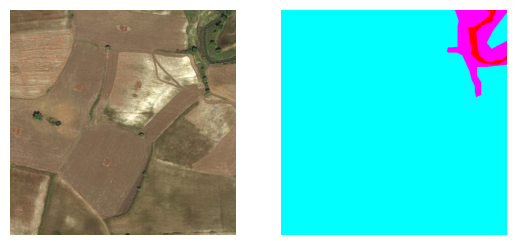

In [ ]:
img = cv2.imread("/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/889920_sat_0.jpg")
label1 = cv2.imread("/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/889920_mask_0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(label1)
plt.axis('off')

plt.show()



---



---



---



In [ ]:
class data_full(object):
    def __init__(self, csv_info, class_dict_path, image_folder_path, transform=None):
      self.img_info = csv_info
      self.image_folder_path = image_folder_path
      self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def getitem(self, i):
        img_path = os.path.join(self.image_folder_path, self.img_info['sat_image_path'][i])
        print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = [self.img_info['urban_land'][i], self.img_info['agriculture_land'][i], self.img_info['rangeland'][i],
                 self.img_info['forest_land'][i], self.img_info['water'][i], self.img_info['barren_land'][i],
                 self.img_info['unknown'][i]]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# path declare
master_path = '/content/drive/MyDrive/APS360Project/archive/cropped_dataset/'
csv_path = master_path + "cropped_proportion.csv"
train_csv_path = master_path + "cropped_proportion_train.csv"
val_csv_path = master_path + "cropped_proportion_valid.csv"
test_csv_path = master_path + "cropped_proportion_test.csv"
class_dict_path = master_path + "class_dict.csv"
image_folder_path = '/content/A'
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
         transforms.Resize((256,256))])

total_info = pd.read_csv(csv_path)
train_info = pd.read_csv(train_csv_path)
val_info = pd.read_csv(val_csv_path)
test_info = pd.read_csv(test_csv_path)

In [ ]:
# load to each set
train_set = []
val_set = []
test_set = []

train_dataset = data_full(train_info, class_dict_path, master_path ,transform=transform)
val_dataset = data_full(val_info, class_dict_path, master_path ,transform=transform)
test_dataset = data_full(test_info, class_dict_path, master_path ,transform=transform)

for i in range(len(train_info['image_id'])):
  train_set.append([train_dataset.getitem(i)])
print("finish train set")

for i in range(len(val_info['image_id'])):
  val_set.append([val_dataset.getitem(i)])
print("finish val set")

for i in range(len(test_info['image_id'])):
  test_set.append([test_dataset.getitem(i)])
print("finish test set")

/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/100694_sat_0.jpg


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/406425_sat_14.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/406425_sat_15.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_0.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_1.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_2.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_3.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_4.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_5.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_6.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_7.jpg
/content/drive/MyDrive/APS360Project/archive/cropped_dataset/train/407467_sat_8.jpg
/content/drive/MyDrive/

In [ ]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=1 ,
                                            shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=1,
                                            shuffle=True)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(612, 612, 3))

# Add a global average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully-connected layer with 512 units and ReLU activation
x = Dense(512, activation='relu')(x)

# Add the output layer with the appropriate number of units
# Since you want to predict a vector representing percentages, use a Dense layer with appropriate activation
predictions = Dense(7, activation='softmax')(x)

# Combine the base model and the new layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base ResNet50 model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_loader, validation_data=val_loader, epochs=10, batch_size = 64)
